In [ ]:
#!pip install modin[all]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import modin.pandas as pd
import numpy as np

df=pd.read_csv("/content/drive/MyDrive/kurly_hackathon/data/2019-Nov.csv") # 2019년 11월 데이터
df1=pd.read_csv("/content/drive/MyDrive/kurly_hackathon/data/2019-Oct.csv") # 2019년 10월 데이터

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

(deploy_ray_func pid=5836) tcmalloc: large alloc 2251694080 bytes == 0x4a48000 @  0x7ff38aed41e7 0x4a3940 0x5b438c 0x5d0ccd 0x5939af 0x516337 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x4bca8a 0x5134a6 0x549576 0x4bca8a 0x5134a6 0x4bc98a 0x7ff387bade02 0x7ff387c41db6 0x7ff387bb4306 0x7ff387d286ab 0x7ff387c8988f 0x7ff387d507d3 0x7ff387d5172a 0x7ff387d6318e 0x7ff387d3c530 0x7ff387f60f06 0x7ff387f0da3e 0x7ff387f0dc96 0x7ff3883a4cab 0x7ff3883a5ee1
(deploy_ray_func pid=5835) tcmalloc: large alloc 2251694080 bytes == 0x43e6000 @  0x7fae6a30a1e7 0x4a3940 0x5b438c 0x5d0ccd 0x5939af 0x516337 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x4bca8a 0x5134a6 0x549576 0x4bca8a 0x5134a6 0x4bc98a 0x7fae66fe3e02 0x7fae67077db6 0x7fae66fea306 0x7fae6715e6ab 0x7fae670bf88f 0x7fae671867d3 0x7fae6718772a 0x7fae6719918e 0x7fae67172530 0x7fae67396f06 0x7fae67343a3e 0x7fae67343c96 0x7fae6

In [ ]:
df=df.loc[df["event_type"].isin(["purchase"])] # 구매를 한 사람만 가져온다.

df=df.reset_index(drop=True)

df1=df1.loc[df1["event_type"].isin(["purchase"])] # 구매를 한 사람만 가져온다.

df1=df1.reset_index(drop=True)

df["event_time"]=df["event_time"].map(lambda x: x.replace(" UTC",""))
df1["event_time"]=df1["event_time"].map(lambda x: x.replace(" UTC",""))

(raylet) Spilled 7156 MiB, 8 objects, write throughput 241 MiB/s.


In [ ]:
def split_category(x):
    if isinstance(x,str):
        category1=x.split(".")[0]
    else: 
        category1=np.nan
    return category1

df["category1"]=df["category_code"].map(lambda x: split_category(x)) # category_code를 "."을 기준으로 나눠서 첫번째 카테고리만 남긴다.
df1["category1"]=df1["category_code"].map(lambda x: split_category(x)) # category_code를 "."을 기준으로 나눠서 첫번째 카테고리만 남긴다.

del df["category_code"],df1["category_code"]


In [ ]:
df=pd.concat([df1, df]) # 2019년 10월, 11월 데이터를 합친다.
df=df.reset_index(drop=True)

del df1 

유저별 아이템 구매 순서를 유지해서 리스트를 각각 만들어줘야함.

In [105]:
df.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,category1
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics


In [ ]:
uid=df["user_id"].unique()

In [ ]:
uid.shape # 구매자 수

(697470,)

In [ ]:
temp=df[["user_id","event_time","product_id"]].copy()

In [ ]:
def get_item_lst(uid):
    t=temp.loc[temp["user_id"].isin([uid])].sort_values(by="event_time")
    return t["product_id"].tolist()

In [ ]:
import pandas as pd
uid_df=pd.DataFrame(uid,columns=["user_id"])

In [ ]:
temp_df=temp.groupby(["user_id"]).count()

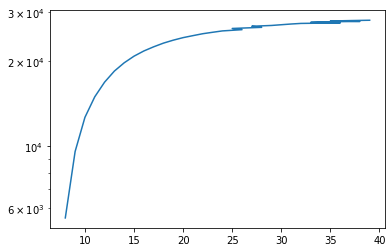

In [ ]:
import matplotlib.pyplot as plt
temp_df[(temp_df["product_id"]>7)&(temp_df["product_id"]<40)]["product_id"].value_counts().cumsum().plot()
plt.yscale("log")

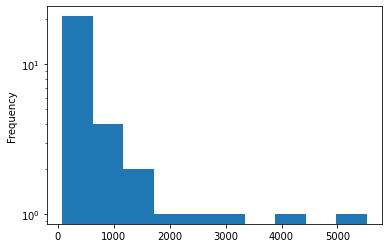

In [ ]:
temp_df[(temp_df["product_id"]>7)&(temp_df["product_id"]<40)]["product_id"].value_counts().plot(kind="hist")
plt.yscale("log")

In [107]:
temp_df[(temp_df["product_id"]>7)&(temp_df["product_id"]<40)].sum()

event_time    379223
product_id    379223
dtype: int64

7개 초과 40개 미만으로 구매한 사람들만 골라낸다.

In [ ]:
range_user=temp_df[(temp_df["product_id"]>7)&(temp_df["product_id"]<40)].index

그 사람들 중에서 1000명만 샘플링을 해서 embedding을 진행하자

In [108]:
np.random.seed(100)
t=np.random.choice(range_user,3000,replace=False) # 구매자 t

In [109]:
path="/content/drive/MyDrive/kurly_hackathon/data/user_save"
np.save(path,t)

In [110]:
%%time
c=pd.Series(t).map(lambda x: get_item_lst(x)) # 구매자 id 리스트: t

CPU times: user 32min 45s, sys: 2min 15s, total: 35min
Wall time: 1h 56min 47s


In [111]:
c=c.map(lambda x: np.array(x)) # numpy로 바꿔주기

In [117]:
arr=np.zeros((3000, 39)) # 0으로 채워진 array를 만든다. 1000개의 row, column은 39개

In [118]:
%%time
for i in range(len(c)):  # c의 product_id번호를 arr에 입력한다.그러면 자동으로 패딩까지 완료
    for j in range(len(c[i])):
        arr[i][j]=c[i][j]

CPU times: user 244 ms, sys: 3.98 ms, total: 248 ms
Wall time: 285 ms


총 몇개의 상품으로 이루어져있나?

In [119]:
plst=[]
for i in c:
    plst.extend(i.tolist()) # 모든 상품

In [120]:
product_size=len(list(set(plst)))
print(product_size) # 총 7318개의 상품

7318


3000명의 구매목록 리스트를 array로 저장

In [121]:
path="/content/drive/MyDrive/kurly_hackathon/data/arr_save"
np.save(path,arr)